# 2D potential toy model: Mueller potential

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import matplotlib
import matplotlib
matplotlib.rcParams.update({'font.size': 16, 'savefig.dpi': 300, 'savefig.bbox': 'tight'})
results_dir = "../results/mueller_potential/"

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from boltzmann_generator import BoltzmannGenerator
from analysis import *
import energy_models.toy_2d_potentials as toy_2d_potentials
MuellerPotential = toy_2d_potentials.MuellerPotential

In [5]:
params = MuellerPotential.default_params.copy()
params['alpha'] = 0.1
mueller = MuellerPotential(params=params)

## Auxiliary scripts

In [6]:
def plot_potential(labels=True, cbar=True, figsize=(7, 4), orientation='vertical', save_as=""):
    # 2D potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    plt.figure(figsize=figsize)
    plt.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    if cbar:
        if orientation == 'horizontal':
            cbar = plt.colorbar(orientation='horizontal', shrink=0.3, aspect=10, anchor=(0.9, 6.5), use_gridspec=False)#, anchor=(0, 0.5))
            cbar.outline.set_linewidth(1)
            cbar.outline.set_color('white')
            cbar.outline.fill = False
            plt.setp(plt.getp(cbar.ax.axes, 'xticklabels'), color='w')
            cbar.ax.xaxis.set_tick_params(color='white')
            cbar.set_label('Energy / kT', labelpad=0, y=0.0, color='white')
        else:
            cbar = plt.colorbar()
            cbar.set_label('Energy / kT', labelpad=-15, y=0.6)
        cbar.set_ticks([-10, 0, 10])
        cbar.set_label('Energy / kT') # , labelpad=-15, y=0.6
        #cbar.set_ticks([-10, -5, 0, 5, 10])
    if labels:
        plt.xlabel('$x_1$')
        plt.ylabel('$x_2$')
        plt.xticks([-1, 0, 1])
        plt.yticks([0, 1, 2])
    else:
        plt.xticks([])
        plt.yticks([])
    if save_as:
        plt.savefig(results_dir + save_as)
    return cbar

In [7]:
def latent_interpolation(bg, x1, x2, nstep=1000):
    lambdas = np.array([np.linspace(0, 1, num=nstep)]).T
    x1 = np.array([x1])
    x2 = np.array([x2])
    z1 = bg.transform_xz(x1)
    z2 = bg.transform_xz(x2)
    z_path = z1 + lambdas*(z2-z1)
    x_path = bg.transform_zx(z_path)
    return x_path

In [8]:
def find_low_energy_transitions(bg, n_output=5, n_trial=100):
    x_paths = []
    max_energies_in_paths = []
    for i in range(n_trial):
        x1 = traj_left[np.random.randint(100)] 
        x2 = traj_right[np.random.randint(100)]
        x_path = latent_interpolation(bg, x1, x2, nstep=1000)
        x_paths.append(x_path)
        max_energies_in_paths.append(np.nanmax(mueller.energy(x_path)))
    
    # Calculate maximal energy in each path
    max_energies_in_paths = np.array(max_energies_in_paths)
    # Determine indices of paths with lowest E_max
    indices = np.argpartition(max_energies_in_paths, n_output)
    lowest_energy_x_paths = []
    for ix in indices[:n_output]:
        lowest_energy_x_paths.append(x_paths[ix])
        
    return lowest_energy_x_paths

## Landscape of potential

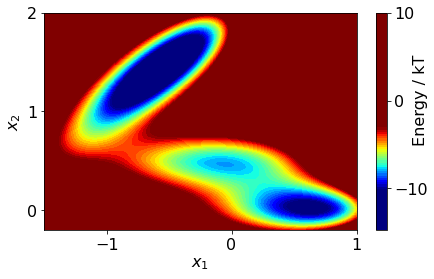

In [9]:
plot_potential(labels=True, cbar=True, save_as="potential_landscape.png")

## Produce training dataset by MC simulation

- Ensure that trajectory of MC simulation for right metastable state (red) does not get to area of intermediate (orange) configurations, which should be not seen by BG during training. If these occurs, rerun the MC simulation. 

In [10]:
from sampling import MetropolisGauss

In [11]:
nsteps = 1000
x0_left = np.array([[-0.5, 1.5]])
x0_right = np.array([[0.5, 0.0]])

sampler = MetropolisGauss(mueller, x0_left, sigma_metro=0.1, stride=10)
sampler.run(nsteps)
traj_left = sampler.trajectory.copy()

sampler.reset(x0_left)
sampler.run(nsteps)
traj_left_val = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right = sampler.trajectory.copy()

sampler.reset(x0_right)
sampler.run(nsteps)
traj_right_val = sampler.trajectory.copy()

In [12]:
x_intermediate = np.array([[-0.05, 0.45]]) + np.array([[0.15, 0.05]]) * np.random.randn(100, 2)

Blue and red configurations are used for training. Orange configurations are used only in validation as a clue.

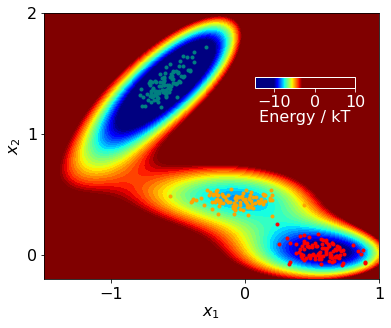

In [13]:
cbar = plot_potential(labels=True, cbar=True, figsize=(6, 7), orientation='horizontal')
plt.plot(traj_left[:, 0], traj_left[:, 1], color='teal', linewidth=0, marker='.')
plt.plot(traj_right[:, 0], traj_right[:, 1], color='red', linewidth=0, marker='.')
plt.plot(x_intermediate[:, 0], x_intermediate[:, 1], color='orange', linewidth=0, marker='.')
plt.savefig(results_dir + "training_dataset.png")

In [14]:
training_dataset = np.vstack([traj_left, traj_right])
validation_dataset = np.vstack([traj_left_val, traj_right_val])

## Define BG parameters
- 5 Real NVP layers are used.
- Each S or T transformation inside Real NVP has 3 hidden layers with 100 units each.
- $y$ ($x_2$) is used as a RC

In [15]:
bg_params = {
    "layers": 'R' * 5, 
    "energy_model": mueller,
    "nl_layers": 3
}

In [16]:
def get_y(x):
    return x[:, 1]

rc_loss_params = {
    "rc_function": get_y,
    "rc_min": -0.1,
    "rc_max": 1.7,
}

In [17]:
def energy_cut_z(ndim, n_std=3):
    z = np.random.randn(10000, ndim)
    z_ener = 0.5 * np.sum(z**2, axis=1)
    std = np.sqrt(np.mean((z_ener - z_ener.mean())**2))
    # mean energies of samples from z + n_std times their standard deviation
    return z_ener.mean() + n_std*std

def low_energy_fraction(energies, E_max):
    low_energy_count = [np.count_nonzero(E<E_max) for E in energies]
    total_size = [E.shape[0] for E in energies]
    low_energy_fraction = np.array(low_energy_count) / total_size
    return low_energy_fraction

In [18]:
z_low_limit = energy_cut_z(2, n_std=1)
# RC entropy is calculated from histogram with 11 bins, see losses.py
max_rc_entropy = np.log(11)  


def plot_convergence(loss_vals, x_energies, z_energies, rc_loss_weight, save_as=""):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    for loss_name in ["loss", "val_loss"]:
        axes[0].plot(loss_vals[loss_name], label=loss_name)
    axes[0].set_xlabel("Iteration")
    axes[0].set_ylabel("Loss")
    axes[0].legend(loc='upper right')
        
    line1, = axes[1].plot(low_energy_fraction(z_energies, E_max=z_low_limit)*100, label="$z$")
    line2, = axes[1].plot(low_energy_fraction(x_energies, E_max=-7)*100, label="$x$")
    axes[1].set_xlabel("Iteration")
    axes[1].set_ylabel("% of samples with $E < E_{low}$")
    axes[1].set_ylim(45, 105)
    
    rc_axis = axes[1].twinx()
    rc_loss = loss_vals.get('RC_loss', np.array([]))
    line3, = rc_axis.plot(-rc_loss/rc_loss_weight/max_rc_entropy, color='green', label="$H_{RC}$")
    rc_axis.yaxis.tick_right()
    rc_axis.set_ylim(0.45,1.05)
    rc_axis.yaxis.set_label_position('right')
    rc_axis.set_ylabel("RC entropy / max possible")
    rc_axis.legend(loc='lower right', handles=[line1, line2, line3])

    if save_as:
        plt.savefig(results_dir + save_as)
    
    plt.subplots_adjust(wspace=0.3)
    plt.show()


    
# Training script
def train_bg(bg, training_schedule, save_as=""):
    for i, args in enumerate(training_schedule):
        input("Should training continue? (press Enter)")
        current_loss_vals, x_energies, z_energies = bg.train(
            training_dataset,
            x_val = validation_dataset,
            weight_ML = args[0],
            weight_KL = args[1],
            weight_RCEnt = args[2],
            iterations = args[3],
            batch_size = args[4],
            lr = args[5],
            print_total_loss_only = True,
            print_training_info_interval = 20,
            return_validation_energies = True,
            **rc_loss_params
        )
        
        plot_convergence(
            current_loss_vals, 
            x_energies, 
            z_energies, 
            rc_loss_weight=args[2],
            save_as=("" if not save_as else save_as+f"_{i}.png")
        )

## Training and valiation scripts

In [25]:
proj_dir = np.array([[0.7],[-0.7]])

def validate_bg(bg, save_as=""):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    plt.subplots_adjust(hspace=0.25, wspace=0.25)
    
    # Sample from BG
    sample_z, sample_x, sample_Ez, sample_Ex, sample_logw = bg.sample(100000)
    proj = sample_x.dot(proj_dir)
    
    # 1.) 2D potential and X samples
    axis = axes[0][0]
    axis.set_title("Samples in X")
    # Plot potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    axis.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    axis.set_xticks([])
    axis.set_yticks([])
    # Plot samples in Z
    axis.plot(sample_x[::10, 0], sample_x[::10, 1], color='white', linewidth=0, marker='.', markersize=2)
    axis.set_xlim(-1.5, 1.0)
    axis.set_ylim(-0.2, 2.0)
    
    # 2.) Plot z distribution
    axis = axes[0][1]
    axis.set_title("Z distribution")
    z_left = bg.transform_xz(traj_left)
    z_int = bg.transform_xz(x_intermediate)
    z_right = bg.transform_xz(traj_right)
    axis.plot(z_left[:, 0], z_left[:, 1], linewidth=0, marker='.', markersize=6, color='blue')
    axis.plot(z_int[:, 0], z_int[:, 1], linewidth=0, marker='.', markersize=6, color='orange')
    axis.plot(z_right[:, 0], z_right[:, 1], linewidth=0, marker='.', markersize=6, color='red')
    circle = plt.Circle((0, 0), radius=1.0, color='black', alpha=0.4, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=2.0, color='black', alpha=0.25, fill=True)
    axis.add_artist(circle)
    circle = plt.Circle((0, 0), radius=3.0, color='black', alpha=0.1, fill=True)
    axis.add_artist(circle)
    axis.set_xlabel('$z_1$')
    axis.set_xlim(-4, 4)
    axis.set_ylabel('$z_2$')
    axis.set_ylim(-4, 4)
    axis.set_yticks([-4, -2, 0, 2, 4]);
    
    # 3.) Free-energy profile
    axis = axes[1][0]
    axis.set_title("Free-energy profile")
    
    # Option 1: Single calculation and using weight cutoff to prevent unreliable predictions
#     # Create weighted histogram of distribution along projection (unnormalized)
#     hist, bin_edges = np.histogram(proj[:, 0], bins=100, weights=np.exp(sample_logw-sample_logw.max()))
#     bin_values = 0.5*(bin_edges[:-1] + bin_edges[1:])
#     # Eliminate low-weight samples
#     hist = np.where(hist < 0.005, np.nan, hist)
#     F_calc = -np.log(hist)
#     F_calc_error = None
    
    # Option 2: Use bootstrap to calculate mean and error
    bin_values, Fs = free_energy_bootstrap(proj[:, 0], 100, (-2, 1), log_weights=sample_logw)
    F_calc = mean_finite(Fs, axis=0)
    F_calc_error = std_finite(Fs, axis=0)
    # Eliminate free-energy predictions with error greater than cutoff
    error_cutoff = 0.6
    F_calc = np.where(F_calc_error > error_cutoff, np.nan, F_calc)
    F_calc_error = np.where(F_calc_error > error_cutoff, np.nan, F_calc_error)
     
    # Create histogram from reference Monte Carlo simulation
    hist_ref, bin_edges = np.histogram(xwild_proj[:, 0], bins=100, weights=xwild_w)
    bin_values_ref = 0.5*(bin_edges[:-1] + bin_edges[1:])
    
    # Calculate free-energy profile
    F_ref = -np.log(hist_ref)
    F_calc_shifted = F_calc - np.nanmin(F_calc) + np.nanmin(F_ref)
    
    # Plot calculated and reference free-energy profiles
    axis.plot(bin_values_ref, F_ref, color='black', linewidth=4)
    axis.errorbar(bin_values, F_calc_shifted, F_calc_error, color='orange', linewidth=2)
    axis.set_xlim(-2, 1)
    axis.set_ylim(-10, 6)
    axis.set_yticks([-10, -5, 0, 5])
    axis.set_xlabel('$x_{proj}$')
    axis.set_ylabel('Free energy / kT', labelpad=-10)
    
    # 4.) Low energy transitions
    axis = axes[1][1]
    axis.set_title("Low-energy transitions")
    
    lowest_energy_x_paths = find_low_energy_transitions(bg)
    
    # Plot potential
    xgrid = np.linspace(-1.5, 1.0, 100)
    ygrid = np.linspace(-0.2, 2, 100)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    X = np.vstack([Xgrid.flatten(), Ygrid.flatten(), np.zeros(Xgrid.size), np.zeros(Xgrid.size)]).T
    E = mueller.energy(X)
    E = E.reshape((100, 100))
    E = np.minimum(E, 10.0)
    axis.contourf(Xgrid, Ygrid, E, 100, cmap='jet', vmin=-10, vmax=-3)
    
    axis.set_xticks([])
    axis.set_xlabel('')
    axis.set_yticks([])
    axis.set_ylabel('')
    for x_path in lowest_energy_x_paths:
        axis.plot(x_path[:, 0], x_path[:, 1], linewidth=2, color='white')
    
    if save_as:
        fig.savefig(results_dir + save_as)

## Calculate reference free energy profile
- 10^6 samples reweighted with Boltzmann factor are used

In [26]:
# Reference free energy calculation:
xwild = np.array([-1.5, -0.2]) + np.array([2.5, 2.2]) * np.random.rand(1000000, 2)
xwild_ener = mueller.energy(xwild)
xwild_w = np.exp(-(xwild_ener-xwild_ener.min()))
xwild_proj = xwild.dot(proj_dir)

## Train and validate Boltzmann generators
- First BG is trained without using RC. Second one uses also RC-entropy loss during training.
- Training dataset in $x$ contains 200 samples.

For each BG, there are 4 figures used for validation:
- Distribution of produced samples (white dots) with potential landscape in background
- Position of $x$ training samples in latent space.
- Calculated free energy profile compared to reference calculation.
- Linear latent interpolation between samples from training dataset.

### BG training without using RC

In [27]:
bg_without_RC = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [28]:
                # w_ML, w_KL, w_RC, iter, b_size, lr
training_shedule = [[1,  0,  0,   100,  500,  1e-3],
                    [1,  1,  0,   300,  1000, 1e-4]]

Should training continue? (press Enter)
Iteration 0/100: loss: 0.77 val_loss: 0.46 
Iteration 20/100: loss: -1.08 val_loss: -1.17 
Iteration 40/100: loss: -1.97 val_loss: -2.03 
Iteration 60/100: loss: -2.68 val_loss: -2.63 
Iteration 80/100: loss: -3.07 val_loss: -2.90 


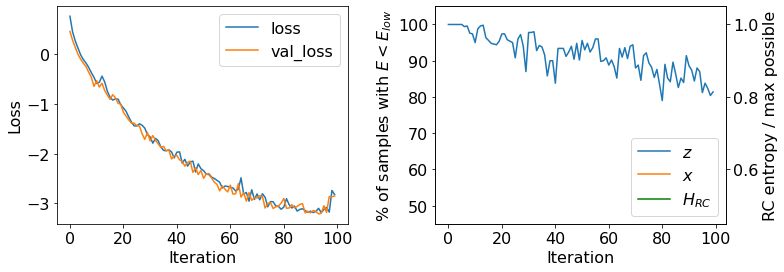

Should training continue? (press Enter)
Iteration 0/300: loss: -9.65 val_loss: -10.10 
Iteration 20/300: loss: -10.92 val_loss: -10.91 
Iteration 40/300: loss: -10.94 val_loss: -10.89 
Iteration 60/300: loss: -11.03 val_loss: -10.94 
Iteration 80/300: loss: -10.96 val_loss: -10.95 
Iteration 100/300: loss: -11.14 val_loss: -11.16 
Iteration 120/300: loss: -11.03 val_loss: -11.02 
Iteration 140/300: loss: -11.12 val_loss: -10.97 
Iteration 160/300: loss: -11.09 val_loss: -11.12 
Iteration 180/300: loss: -11.19 val_loss: -11.14 
Iteration 200/300: loss: -11.11 val_loss: -11.20 
Iteration 220/300: loss: -11.12 val_loss: -11.26 
Iteration 240/300: loss: -11.27 val_loss: -11.16 
Iteration 260/300: loss: -11.23 val_loss: -11.33 
Iteration 280/300: loss: -11.27 val_loss: -11.31 


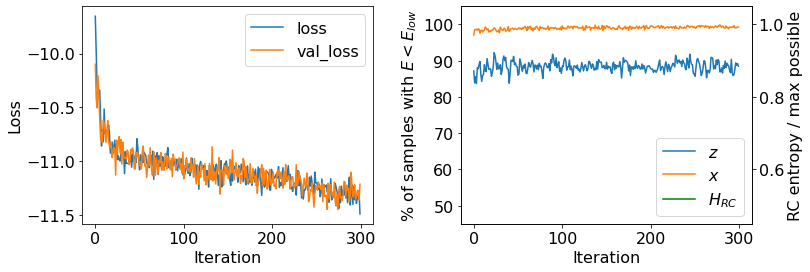

In [29]:
train_bg(bg_without_RC, training_shedule)

../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


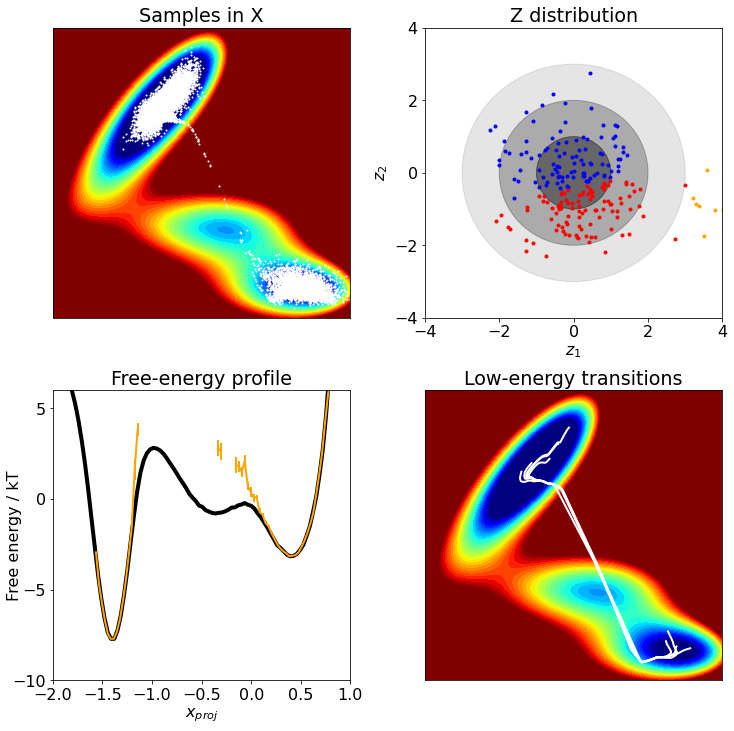

In [30]:
validate_bg(bg_without_RC, "results_without_RC")

### BG training using RC

In [141]:
bg_with_RC = BoltzmannGenerator(**bg_params)

Layers of invertible NN: <RRRRR>
< 2 0 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
R 1 1 0
> 1 1 0


In [142]:
training_shedule = [
  # w_ML, w_KL, w_RC, iter, b_size, lr
    [1,     0,   0,   100,   1000,  1e-3],
    [1,     1,   3,   200,   4000,  1e-4],
    [0.1,   1,   3,   200,   4000,  1e-4]
]

Should training continue? (press Enter)
Iteration 0/100: loss: 0.78 val_loss: 0.46 
Iteration 20/100: loss: -1.17 val_loss: -1.25 
Iteration 40/100: loss: -2.48 val_loss: -2.51 
Iteration 60/100: loss: -2.82 val_loss: -2.98 
Iteration 80/100: loss: -3.23 val_loss: -3.18 


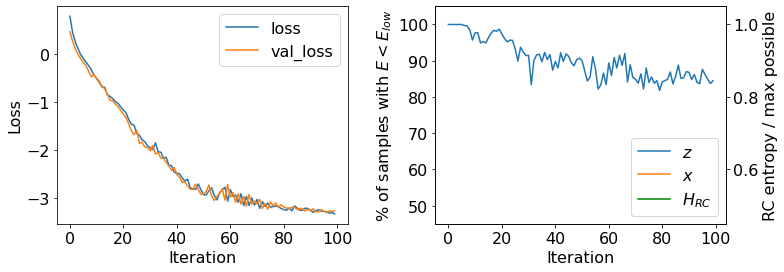

Should training continue? (press Enter)
Iteration 0/200: loss: -16.85 val_loss: -16.81 
Iteration 20/200: loss: -17.20 val_loss: -17.19 
Iteration 40/200: loss: -17.38 val_loss: -17.37 
Iteration 60/200: loss: -17.41 val_loss: -17.41 
Iteration 80/200: loss: -17.49 val_loss: -17.48 
Iteration 100/200: loss: -17.56 val_loss: -17.50 
Iteration 120/200: loss: -17.56 val_loss: -17.54 
Iteration 140/200: loss: -17.52 val_loss: -17.53 
Iteration 160/200: loss: -17.58 val_loss: -17.54 
Iteration 180/200: loss: -17.58 val_loss: -17.56 


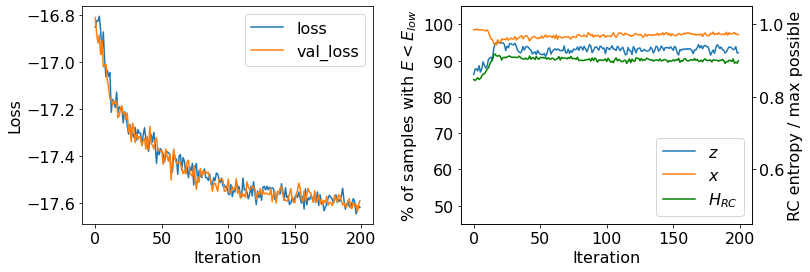

Should training continue? (press Enter)
Iteration 0/200: loss: -14.88 val_loss: -14.88 
Iteration 20/200: loss: -14.92 val_loss: -14.89 
Iteration 40/200: loss: -14.98 val_loss: -14.94 
Iteration 60/200: loss: -14.95 val_loss: -14.91 
Iteration 80/200: loss: -15.00 val_loss: -14.97 
Iteration 100/200: loss: -15.00 val_loss: -15.00 
Iteration 120/200: loss: -14.99 val_loss: -15.00 
Iteration 140/200: loss: -14.98 val_loss: -15.01 
Iteration 160/200: loss: -14.99 val_loss: -15.01 
Iteration 180/200: loss: -14.98 val_loss: -15.01 


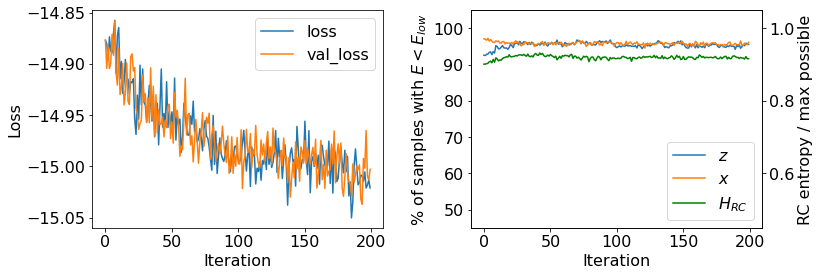

In [143]:
train_bg(bg_with_RC, training_shedule, save_as="training_stats_with_RC")

../analysis.py:116: RuntimeWarning: divide by zero encountered in log
  free_energy = -np.log(probability_density_for_sample)


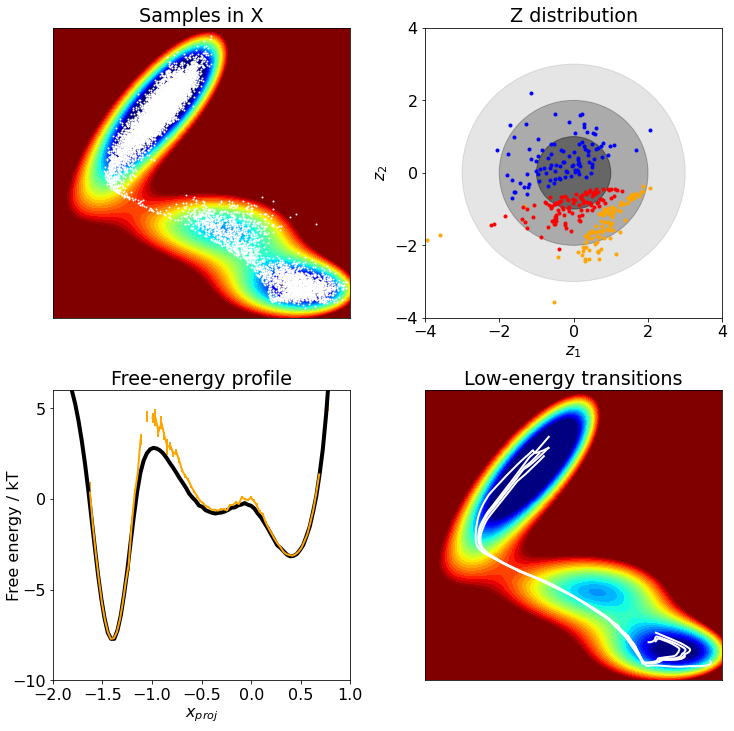

In [144]:
validate_bg(bg_with_RC, "results_with_RC")

### Create images to be used in figures of diploma thesis

In [145]:
# Sample from BG
sample_z, sample_x, sample_Ez, sample_Ex, sample_logw = bg_with_RC.sample(100000)
proj = sample_x.dot(proj_dir).flatten()

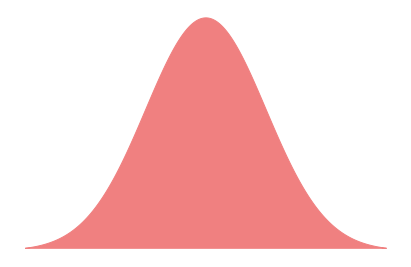

In [146]:
x = np.linspace(-3, 3, 200)
y = np.exp(-0.5*x**2)

axis = plt.gca()
plt.fill(x, y, color='lightcoral')

axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig("../results/general/pdf_normal.pdf")

In [147]:
# Use this to lower the peaks
def linlogcut(x, a=1e6, b=1):
    y = a + np.where(x < a, x - a, np.log10(x - a + 1)*b)
    return y

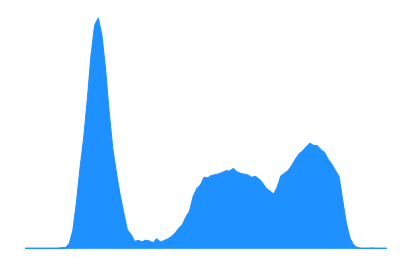

In [148]:
hist, bins = np.histogram(proj, 100, (-2, 1), density=True)
bins = 0.5 * (bins[:-1] + bins[1:])

axis = plt.gca()
plt.fill(bins, linlogcut(hist, 0.1, 0.3), color='dodgerblue')

axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig("../results/general/pdf_unweighted.pdf")

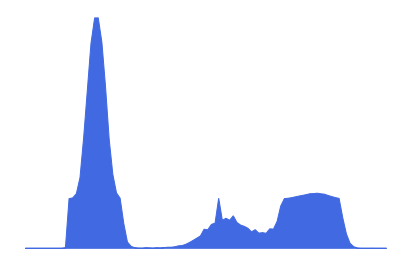

In [149]:
hist, _ = np.histogram(proj, 100, (-2, 1), weights=np.exp(sample_logw), density=True)

axis = plt.gca()
plt.fill(bins, linlogcut(hist, 0.01, 0.04), color='royalblue')

axis.get_xaxis().set_visible(False)
axis.get_yaxis().set_visible(False)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
plt.tight_layout()
plt.savefig("../results/general/pdf_weighted.pdf")